In [10]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

# Specific IC stuff
import IC.invisible_cities.core.system_of_units  as units


#Necessary to open configuration information
from IC.invisible_cities.io.mcinfo_io import load_mcconfiguration
from IC.invisible_cities.io.mcinfo_io import load_mcparticles_df
from IC.invisible_cities.io.mcinfo_io import load_mchits_df
from IC.invisible_cities.io.mcinfo_io import load_mcsensor_positions
from IC.invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from IC.invisible_cities.io.mcinfo_io import get_sensor_types
from IC.invisible_cities.io.mcinfo_io import get_sensor_binning
from IC.invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from IC.invisible_cities.core.core_functions import in_range

In [4]:
import functions.histo_functions as myhf
import functions.efficiency_functions as myef
import functions.recovstrue as myrvt

In [20]:
filepath = '/Users/halmamol/NEXT/files/simulations/NEW_NeutronGun_dir/'
filename_single = 'NEW_NeutronGun_216_dir.next.h5'
maxfiles = 230
file = filepath+filename_single
#SiPM pitch hardcoded
sipm_pitch = 10 #mm

In [33]:
eventID = 108004
ngenerated = maxfiles*500

In [78]:
def isotopes_nCaptureFraction(ninit, particles):
    
    mother_particles = particles[particles.primary == 1]
    daughter_particles = particles[particles.mother_id == 1]
    
    ninteractions_nCapture = mother_particles[mother_particles.final_proc == "nCapture"].event_id.nunique()
    frac_ninteractions_nCapture = "{:.2f}".format(100*ninteractions_nCapture/ninit)
    
    print(f'Neutron Capture {frac_ninteractions_nCapture}%')

    #Xe132
    nCaptXe132 = daughter_particles[(daughter_particles.creator_proc == "nCapture")
                                 & (daughter_particles.particle_name == "Xe132")].event_id.nunique()
    fracXe132 = "{:.2f}".format(100*nCaptXe132/ninit)
    #Cu64
    nCaptCu64 = daughter_particles[(daughter_particles.creator_proc == "nCapture")
                                 & (daughter_particles.particle_name == "Cu64")].event_id.nunique()
    fracCu64 = "{:.2f}".format(100*nCaptCu64/ninit)
    #deuteron
    nCaptdeuteron = daughter_particles[(daughter_particles.creator_proc == "nCapture")
                                 & (daughter_particles.particle_name == "Xe132")].event_id.nunique()
    fracdeuteron = "{:.2f}".format(100*nCaptdeuteron/ninit)
    #Cu66
    nCaptCu66 = daughter_particles[(daughter_particles.creator_proc == "nCapture")
                                 & (daughter_particles.particle_name == "Cu66")].event_id.nunique()
    fracCu66 = "{:.2f}".format(100*nCaptCu66/ninit)
    #Xe130
    nCaptXe130 = daughter_particles[(daughter_particles.creator_proc == "nCapture")
                                 & (daughter_particles.particle_name == "Xe130")].event_id.nunique()
    fracXe130 = "{:.2f}".format(100*nCaptXe130/ninit)

    #F20
    nCaptF20 = daughter_particles[(daughter_particles.creator_proc == "nCapture")
                                 & (daughter_particles.particle_name == "F20")].event_id.nunique()
    fracF20 = "{:.2f}".format(100*nCaptF20/ninit)

    print('Neutron Capture isotopes')
    print(f'- Xe132 {nCaptXe132}->{fracXe132}%')
    print(f'- Cu64 {nCaptCu64}->{fracCu64}%')
    print(f'- deuteron {nCaptdeuteron}->{fracdeuteron}%')
    print(f'- Cu66 {nCaptCu66}->{fracCu66}%')
    print(f'- Xe130 {nCaptXe130}->{fracXe130}%')
    print(f'- F20 {nCaptF20}->{fracF20}%')


In [79]:
def isotopes_ineScattFraction(ninit, particles):
    
    mother_particles = particles[particles.primary == 1]
    daughter_particles = particles[particles.mother_id == 1]
    
    ninteractions_IneScatt= mother_particles[mother_particles.final_proc == "nCapture"].event_id.nunique()
    frac_ninteractions_IneScatt = "{:.2f}".format(100*ninteractions_IneScatt/ninit)
    
    print(f'Inelastic Scattering {frac_ninteractions_IneScatt}%')
    #F19
    nCaptF19 = daughter_particles[(daughter_particles.creator_proc == "neutronInelastic")
                                 & (daughter_particles.particle_name == "F19")].event_id.nunique()
    fracF19 = "{:.2f}".format(100*nCaptF19/ninit)
    #Fe57
    nCaptFe57 = daughter_particles[(daughter_particles.creator_proc == "neutronInelastic")
                                 & (daughter_particles.particle_name == "Fe57")].event_id.nunique()
    fracFe57 = "{:.2f}".format(100*nCaptFe57/ninit)
    #Xe129
    nCaptXe129 = daughter_particles[(daughter_particles.creator_proc == "neutronInelastic")
                                 & (daughter_particles.particle_name == "Xe129")].event_id.nunique()
    fracXe129 = "{:.2f}".format(100*nCaptXe129/ninit)
    #Xe131
    nCaptXe131 = daughter_particles[(daughter_particles.creator_proc == "neutronInelastic")
                                 & (daughter_particles.particle_name == "Xe131")].event_id.nunique()
    fracXe131 = "{:.2f}".format(100*nCaptXe131/ninit)

    print('Inelastic Scattering isotopes')
    print(f'- F19 {nCaptF19}->{fracF19}%')
    print(f'- Fe57 {nCaptFe57}->{fracFe57}%')
    print(f'- Xe129 {nCaptXe129}->{fracXe129}%')
    print(f'- Xe131 {nCaptXe131}->{fracXe131}%')


## Loading SiPM sns MAP

In [13]:
sipm_map = pd.read_csv("sipm_map.csv")

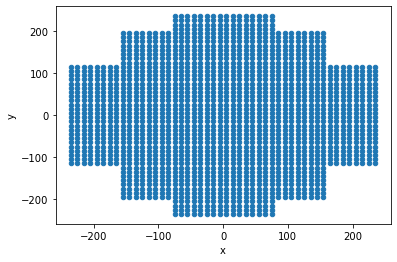

In [14]:
sipm_map.plot(kind='scatter', x='x', y='y')

In [15]:
sipm_map

,Unnamed: 0,sensor_id,sensor_name,x,y,xl,xr,yu,yd,id_xl,id_xr,id_yu,id_yd
0,0,6047,SiPM,-105.0,35.0,-115.0,-95.0,45.0,25.0,6039,6055,5040,6046
1,1,6039,SiPM,-115.0,35.0,-125.0,-105.0,45.0,25.0,6031,6047,5032,6038
2,2,22031,SiPM,115.0,115.0,105.0,125.0,125.0,105.0,22023,22039,21024,22030
3,3,5009,SiPM,-145.0,55.0,-155.0,-135.0,65.0,45.0,5001,5017,5010,5008
4,4,6036,SiPM,-115.0,5.0,-125.0,-105.0,15.0,-5.0,6028,6044,6037,6035
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1787,1799,1015,SiPM,-225.0,115.0,-235.0,-215.0,-999999.0,105.0,1007,1023,-999999,1014
1788,1800,1007,SiPM,-235.0,115.0,-999999.0,-225.0,-999999.0,105.0,-999999,1015,-999999,1006
1789,1801,1012,SiPM,-225.0,85.0,-235.0,-215.0,95.0,75.0,1004,1020,1013,1011
1790,1802,3000,SiPM,-235.0,-115.0,-999999.0,-225.0,-105.0,-999999.0,-999999,3008,3001,-999999


## Loading Files

### Particles True Info

In [22]:
particles_list = []

for nfile in range(1,maxfiles):
    
    filename = filepath+f'NEW_NeutronGun_{nfile}_dir.next.h5'
    try:
        readfile_particles = pd.read_hdf(filename, 'MC/particles')
    except:
        print('File {} not good'.format(filename))
        continue
        
    particles_list.append(readfile_particles)
    

particles = pd.concat([dt for dt in particles_list]) 
particles.columns  

File /Users/halmamol/NEXT/files/simulations/NEW_NeutronGun_dir/NEW_NeutronGun_207_dir.next.h5 not good


Index(['event_id', 'particle_id', 'particle_name', 'primary', 'mother_id',
       'initial_x', 'initial_y', 'initial_z', 'initial_t', 'final_x',
       'final_y', 'final_z', 'final_t', 'initial_volume', 'final_volume',
       'initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
       'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
       'kin_energy', 'length', 'creator_proc', 'final_proc'],
      dtype='object')

In [31]:
#particles_evt = particles[particles.event_id == eventID]
mother_particles = particles[particles.primary == 1]
daughter_particles = particles[particles.mother_id == 1]

### Hits True Info

In [24]:
hits_list = []

for nfile in range(1,maxfiles):
    
    filename = filepath+f'NEW_NeutronGun_{nfile}_dir.next.h5'
    try:
        readfile_hits = pd.read_hdf(filename, 'MC/hits')
    except:
        print('File {} not good'.format(filename))
        continue
        
    hits_list.append(readfile_particles)
    

hits = pd.concat([dt for dt in hits_list]) 
hits.columns  

File /Users/halmamol/NEXT/files/simulations/NEW_NeutronGun_dir/NEW_NeutronGun_207_dir.next.h5 not good


Index(['event_id', 'particle_id', 'particle_name', 'primary', 'mother_id',
       'initial_x', 'initial_y', 'initial_z', 'initial_t', 'final_x',
       'final_y', 'final_z', 'final_t', 'initial_volume', 'final_volume',
       'initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
       'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
       'kin_energy', 'length', 'creator_proc', 'final_proc'],
      dtype='object')

### Sensors info 

In [69]:
#Sensors info - ID
sns_list = []

for nfile in range(1,maxfiles):
    
    filename = filepath+f'NEW_NeutronGun_{nfile}_dir.next.h5'
    try:
        readfile_sns = pd.read_hdf(filename, 'MC/sns_response')
    except:
        print('File {} not good'.format(filename))
        continue
        
    sns_list.append(readfile_sns)
    

sns_response = pd.concat([dt for dt in sns_list]) 
sns_response.columns  

File /Users/halmamol/NEXT/files/simulations/NEW_NeutronGun_dir/NEW_NeutronGun_207_dir.next.h5 not good


Index(['event_id', 'sensor_id', 'time_bin', 'charge'], dtype='object')

## Checking Interactions Prior Selection

In [35]:
ninteractions = mother_particles.event_id.nunique()
print(f'Number of events interacting {ninteractions}->{100*ninteractions/ngenerated}%')

Number of events interacting 11886->10.335652173913044%


In [38]:
ninteractions_nInelastic = mother_particles[mother_particles.final_proc == "neutronInelastic"].event_id.nunique()
ninteractions_nCapture = mother_particles[mother_particles.final_proc == "nCapture"].event_id.nunique()
ninteractions_Transportation = mother_particles[mother_particles.final_proc == "Transportation"].event_id.nunique()
ninteractions_UserSpecialCut = mother_particles[mother_particles.final_proc == "UserSpecialCut"].event_id.nunique()

print(f'Inelastic scattering {100*ninteractions_nInelastic/ninteractions}%')
print(f'Neutron Capture {100*ninteractions_nCapture/ninteractions}%')
print(f'Transportation {100*ninteractions_Transportation/ninteractions}%')
print(f'"User Special Cut" {100*ninteractions_UserSpecialCut/ninteractions}%')

Inelastic scattering 0.0%
Neutron Capture 99.4278983678277%
Transportation 0.0%
"User Special Cut" 0.5721016321723036%


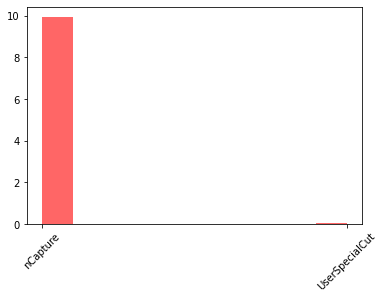

In [41]:
neutron_interactions = mother_particles.final_proc
plt.hist(neutron_interactions, alpha=0.6, color='r', density = True)
plt.xticks(rotation=45)

plt.show()

In [46]:
nCapture = daughter_particles[(daughter_particles.creator_proc == "nCapture")
                             & (daughter_particles.particle_name != "gamma")].particle_name

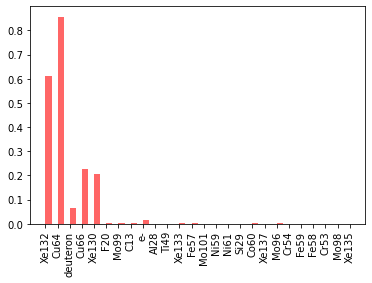

In [47]:
plt.hist(nCapture, density=True, alpha=0.6, bins = 50, color='r')
plt.xticks(rotation=90)

plt.show()

In [80]:
isotopes_nCaptureFraction(ninteractions, particles)

Neutron Capture 99.43%
Neutron Capture isotopes
- Xe132 3646->30.67%
- Cu64 5100->42.91%
- deuteron 3646->30.67%
- Cu66 1340->11.27%
- Xe130 1223->10.29%
- F20 12->0.10%


In [43]:
n_inelscatt = daughter_particles[(daughter_particles.creator_proc == "neutronInelastic") 
                   & (daughter_particles.particle_name != "gamma") 
                   & (daughter_particles.particle_name != "neutron") ].particle_name

/Users/halmamol/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


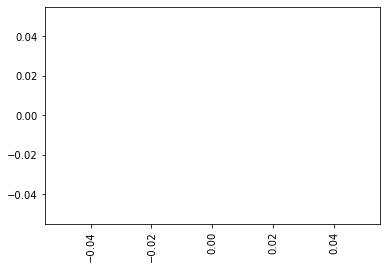

In [44]:
plt.hist(n_inelscatt, density=True, alpha=0.6, bins = 50, color='r')
plt.xticks(rotation=90)

plt.show()

In [81]:
isotopes_ineScattFraction(ninteractions, particles)


Inelastic Scattering 99.43%
Inelastic Scattering isotopes
- F19 0->0.00%
- Fe57 0->0.00%
- Xe129 0->0.00%
- Xe131 0->0.00%


## CUT Selection

Events selected under the following cuts:
- **Cut 0**: qSiPM > Eth
- **Cut 1**: Fiducial cut
- **Cut 2**: Ncluster = 2
- **Cut 3**: Energy Cut for Cluster

## Preliminary Cut

In [84]:
sns_response_eth = sns_response[sns_response.charge > 3]
ninteractions_eth = sns_response_eth.event_id.nunique()
ninteractions_eth

8853

In [85]:
sns_response_eth_list = sns_response_eth.event_id.unique()

# I get a list of true elements if event ID is in the above list
evt_sns_response_eth = particles.event_id.isin(sns_response_eth_list) 

# And finally I select the events with an asigned True from the previous line 
particles_eth = particles[evt_sns_response_eth]

particles_eth.event_id.nunique()

8853

In [92]:
print(f'--INITIAL-- {ninteractions} events')
isotopes_nCaptureFraction(ninteractions, particles)
print(f'--PRELIMINARY-- {ninteractions_eth} events -> reduction {100*(1-ninteractions_eth/ninteractions)}%')
isotopes_nCaptureFraction(ninteractions_eth, particles_eth)

--INITIAL-- 11886 events
Neutron Capture 99.43%
Neutron Capture isotopes
- Xe132 3646->30.67%
- Cu64 5100->42.91%
- deuteron 3646->30.67%
- Cu66 1340->11.27%
- Xe130 1223->10.29%
- F20 12->0.10%
--PRELIMINARY-- 8853 events -> reduction 25.517415446744074%
Neutron Capture 100.00%
Neutron Capture isotopes
- Xe132 1710->19.32%
- Cu64 4466->50.45%
- deuteron 1710->19.32%
- Cu66 1218->13.76%
- Xe130 1040->11.75%
- F20 10->0.11%


## Fiducial cut

I'm going to apply the fiducial cuts considered in the NEW analysis:
- r<180mm
- 20mm < z <510mm

In [93]:
rmax = 180
zmin = 20
zmax = 510

In [110]:
sipm_map
len(sipm_map.sensor_id)

1792

In [119]:
#Check in SiPm list which ones are out of the limits
sns_fid_list = []

for entry in range(0,len(sipm_map.sensor_id)):
    sns = sns_response_eth.sensor_id.values[entry]
    try:
        x_pos = sipm_map[sipm_map.sensor_id == sns].x.values[0]
        y_pos = sipm_map[sipm_map.sensor_id == sns].y.values[0]
    except:
        continue
    r_pos = math.sqrt(x_pos**2+y_pos**2)
    if (r_pos < rmax):
        sns_fid_list.append(sns)

In [125]:
# I get a list of true elements if event ID is in the above list
evt_sns_response_fideth = sns_response_eth.sensor_id.isin(sns_fid_list) 

# And finally I select the events with an asigned True from the previous line 
sns_response_fideth = sns_response_eth[evt_sns_response_fideth]

sns_response_fideth.event_id.nunique()

2585

In [141]:
nonfiducial_list = sns_response_fideth.event_id.unique()
# I get a list of true elements if event ID is in the above list
evt_sns_response_fideth = ~particles_eth.event_id.isin(nonfiducial_list) 
# And finally I select the events with an asigned True from the previous line 
particles_fideth = particles_eth[~evt_sns_response_fideth]

particles_fideth.event_id.nunique()

2585

In [192]:
selectedSiPM, selectedSiPM_x, selectedSiPM_y, selectedSiPM_q = [], [], [], []
sns_response_evt = sns_response_fideth[sns_response_fideth.event_id == 503]

total = len(sns_response_evt.event_id)-1
for entry in range(0,total):
    sns = sns_response_evt.sensor_id.values[entry]
    q = sns_response_evt.charge.values[entry]
    #note! SiPM have a sns number >100, while PMTs are defined below 100 
    if(sns > 1000):
        x_pos = sipm_map[sipm_map.sensor_id == sns].x.values[0]
        y_pos = sipm_map[sipm_map.sensor_id == sns].y.values[0]
        selectedSiPM_x.append(x_pos)
        selectedSiPM_y.append(y_pos)
        selectedSiPM_q.append(q)
    else:
        continue
    
selectedSiPM.append(selectedSiPM_x)
selectedSiPM.append(selectedSiPM_y)
selectedSiPM.append(selectedSiPM_q)

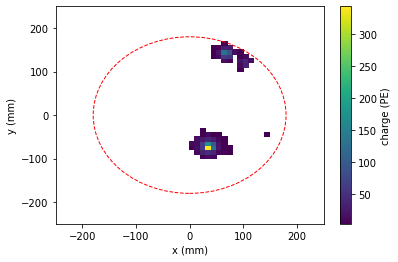

In [193]:
fig, ax = plt.subplots()
weights = myhf.get_weights(selectedSiPM[0], True)

plt.hist2d(selectedSiPM[0], selectedSiPM[1], weights = selectedSiPM[2], bins=(50, 50), range=((-250, 250), (-250, 250)), cmap='viridis', cmin=0.001)
circle1 = plt.Circle((0, 0), 180, edgecolor = 'red', fill = False ,linestyle = '--')
ax.add_artist(circle1)
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
#plt.title('charge (PE)')

plt.colorbar(label='charge (PE)')

In [263]:
posXY = np.array([np.array([x,y]) for x,y in zip(selectedSiPM[0], selectedSiPM[1])])
Qs  = np.array(selectedSiPM[2])
c_i = barycenter(posXY, Qs)
c_i

[< nsipm = 153 Q = 1988
                     xy = xy(x=49.77867203219316, y=-1.6851106639839035) 3dHit = Cluster(49.77867203219316, -1.6851106639839035, -9.425, E=1988)  >]

In [284]:
clusters = corona(posXY, Qs, sipm_map,
           #charge threshold, ignore all SiPMs with less than Qthr pes
           Qthr            =  5 * units.pes,
           #charge threshold, every Cluster must contain at least one SiPM with charge >= Qlm
           Qlm             =  20 * units.pes,
           #radius, find new_local_maximum by taking the barycenter of SiPMs within lm_radius of the max sipm.
           #In general lm_radius should typically be set to 0, or some value slightly larger than pitch or pitch*sqrt(2)
           lm_radius       =  sipm_pitch*math.sqrt(2) * units.mm,
           #radius, find a new cluster by calling barycenter() on pos/qs of SiPMs within new_lm_radius of new_local_maximum
           new_lm_radius   = sipm_pitch*math.sqrt(2) * units.mm,
           #minimum number of SiPMs in a Cluster  
           msipm           =  5,
           consider_masked = False)
clusters

[< nsipm = 28 Q = 912
                     xy = xy(x=36.041666666666664, y=-71.8640350877193) 3dHit = Cluster(36.041666666666664, -71.8640350877193, -9.425, E=912)  >,
 < nsipm = 26 Q = 411
                     xy = xy(x=68.43065693430657, y=143.661800486618) 3dHit = Cluster(68.43065693430657, 143.661800486618, -9.425, E=411)  >,
 < nsipm = 8 Q = 74
                     xy = xy(x=48.513513513513516, y=-83.24324324324324) 3dHit = Cluster(48.513513513513516, -83.24324324324324, -9.425, E=74)  >,
 < nsipm = 13 Q = 114
                     xy = xy(x=35.96491228070175, y=-53.333333333333336) 3dHit = Cluster(35.96491228070175, -53.333333333333336, -9.425, E=114)  >]

In [278]:
clusters[0].X

36.041666666666664

In [285]:
bx = np.array([clusters[0].X, clusters[1].X, clusters[2].X, clusters[3].X], dtype=np.float)
by = np.array([clusters[0].Y, clusters[1].Y, clusters[2].Y, clusters[3].Y], dtype=np.float)

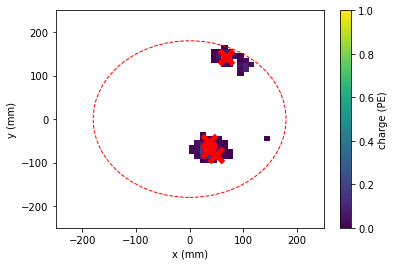

In [286]:
fig, ax = plt.subplots()
weights = myhf.get_weights(selectedSiPM[0], True)

plt.hist2d(selectedSiPM[0], selectedSiPM[1], weights = selectedSiPM[2], bins=(50, 50), range=((-250, 250), (-250, 250)), cmap='viridis', cmin=0.001)
circle1 = plt.Circle((0, 0), 180, edgecolor = 'red', fill = False ,linestyle = '--')
plt.scatter(bx, by, marker='x', s=200, linewidth=5, color='red')
ax.add_artist(circle1)
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
#plt.title('charge (PE)')

plt.colorbar(label='charge (PE)')

In [289]:
max(sns_response.event_id.unique())

114541

In [312]:
nClusters = []
totevt = max(sns_response.event_id.unique())

for evt in range(0,totevt):
    selectedSiPM, selectedSiPM_x, selectedSiPM_y, selectedSiPM_q = [], [], [], []
    sns_response_evt = sns_response_fideth[sns_response_fideth.event_id == evt]

    total = len(sns_response_evt.event_id)-1
    for entry in range(0,total):
        sns = sns_response_evt.sensor_id.values[entry]
        q = sns_response_evt.charge.values[entry]
        #note! SiPM have a sns number >100, while PMTs are defined below 100 
        if(sns > 1000):
            x_pos = sipm_map[sipm_map.sensor_id == sns].x.values[0]
            y_pos = sipm_map[sipm_map.sensor_id == sns].y.values[0]
            selectedSiPM_x.append(x_pos)
            selectedSiPM_y.append(y_pos)
            selectedSiPM_q.append(q)
        else:
            continue

    selectedSiPM.append(selectedSiPM_x)
    selectedSiPM.append(selectedSiPM_y)
    selectedSiPM.append(selectedSiPM_q)
    
    posXY = np.array([np.array([x,y]) for x,y in zip(selectedSiPM[0], selectedSiPM[1])])
    Qs  = np.array(selectedSiPM[2])

    if(posXY.any() != 0):
        try:
            clusters = corona(posXY, Qs, sipm_map,
                   #charge threshold, ignore all SiPMs with less than Qthr pes
                   Qthr            =  5 * units.pes,
                   #charge threshold, every Cluster must contain at least one SiPM with charge >= Qlm
                   Qlm             =  20 * units.pes,
                   #radius, find new_local_maximum by taking the barycenter of SiPMs within lm_radius of the max sipm.
                   #In general lm_radius should typically be set to 0, or some value slightly larger than pitch or pitch*sqrt(2)
                   lm_radius       =  sipm_pitch*math.sqrt(2) * units.mm,
                   #radius, find a new cluster by calling barycenter() on pos/qs of SiPMs within new_lm_radius of new_local_maximum
                   new_lm_radius   = sipm_pitch*math.sqrt(2) * units.mm,
                   #minimum number of SiPMs in a Cluster  
                   msipm           =  5,
                   consider_masked = False)
        except:
            continue
        #print(clusters)
        nClusters.append(len(clusters))


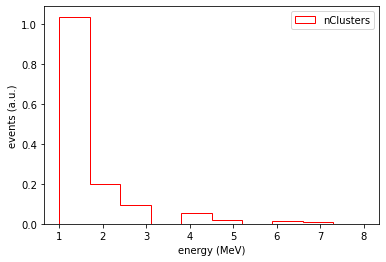

In [313]:
nClusters
plt.hist(nClusters, color='red', histtype='step', density = True, label = 'nClusters')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.legend(loc=1);
plt.show()

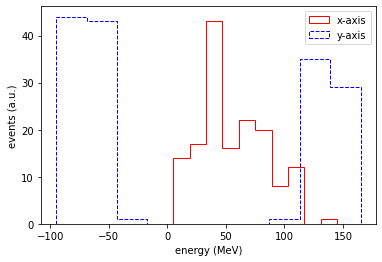

In [239]:
plt.hist(selectedSiPM[0], color='red', histtype='step', label = 'x-axis')
plt.hist(selectedSiPM[1],  color='blue', histtype='step', label = 'y-axis', linestyle='dashed')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.legend(loc=1);
plt.show()

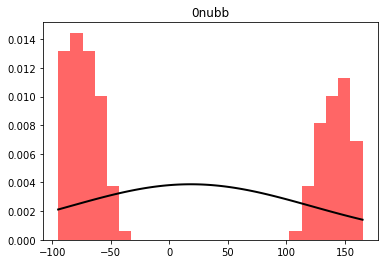

Fit results: mu = 18.26797385620915,  std = 102.91712552320969 
-2.526304525881509


In [249]:
from scipy.stats import norm
from scipy.stats import exponnorm
from scipy.stats import skewnorm
mu, std = norm.fit(selectedSiPM[1])

# Plot the histogram.
plt.hist(selectedSiPM[1], bins=25, density=True, alpha=0.6, color='r')

# Plot the PDF.
x = np.linspace(min(selectedSiPM[1]), max(selectedSiPM[1]), 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title('0nubb')

plt.show()

print(f'Fit results: mu = {mu},  std = {std} ')
print((min(selectedSiPM[1]) - max(selectedSiPM[1]))/std)

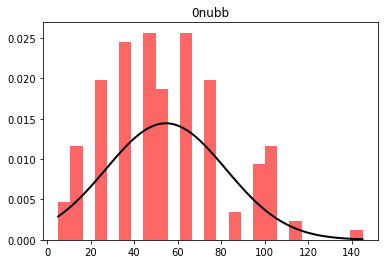

Fit results: mu = 54.54248366013072,  std = 27.614050351912674 
-140.0


In [248]:
mu, std = norm.fit(selectedSiPM[0])

# Plot the histogram.
plt.hist(selectedSiPM[0], bins=25, density=True, alpha=0.6, color='r')

# Plot the PDF.
x = np.linspace(min(selectedSiPM[0]), max(selectedSiPM[0]), 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title('0nubb')

plt.show()

print(f'Fit results: mu = {mu},  std = {std} ')
print(min(selectedSiPM[0]) - max(selectedSiPM[0]))

In [215]:
from sklearn.cluster import KMeans

In [232]:
kmeans = KMeans(
   ...:     init="random",
   ...:     n_clusters=2,
   ...:     n_init=10,
   ...:     max_iter=300,
   ...:     random_state=42
   ...: )                    # haz 8 grupos con nuestros datos

In [233]:
kmeans.fit(sns_response_evt)

KMeans(init='random', n_clusters=2, random_state=42)

In [236]:
kmeans.cluster_centers_

array([[5.03000000e+02, 2.14327500e+04, 3.16041667e+02, 7.16666667e+00],
       [5.03000000e+02, 1.75285923e+04, 3.05869231e+02, 1.40000000e+01]])

In [231]:
#Initialize the class object
kmeans = KMeans(n_clusters= 2)
 
#predict the labels of clusters.
label = kmeans.fit_predict(sns_response_evt)
 
print(label)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0
 0 0 0 0 1 1]


In [250]:
part_evt = particles_fideth[particles_fideth.event_id == 503]
part_evt[part_evt.primary == 0]

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
280,503,4,Cu64,0,1,95.001213,10.520631,-21.435419,2.585205e+05,95.001213,...,5.404075,-12.272764,0.766734,0.000000,-0.000000,0.000000,0.001515,1.934358e-05,nCapture,Scintillation
281,503,9,nu_e,0,4,95.001213,10.520631,-21.435419,5.175836e+13,-4322.083984,...,-0.545645,1.542831,0.312564,-0.545645,1.542831,0.312564,1.666059,1.348703e+04,RadioactiveDecay,Transportation
282,503,8,Ni64,0,4,95.001213,10.520631,-21.435419,5.175836e+13,95.001221,...,0.545645,-1.542831,-0.312564,0.000000,-0.000000,-0.000000,0.000023,2.465939e-06,RadioactiveDecay,Scintillation
283,503,7,gamma,0,4,95.001213,10.520631,-21.435419,5.175836e+13,95.000359,...,-0.000230,0.001937,-0.007157,-0.000000,0.000000,-0.000000,0.007418,2.766065e-02,RadioactiveDecay,phot
284,503,12,e-,0,7,95.000359,10.527856,-21.462105,5.175836e+13,95.000359,...,-0.007547,-0.001325,-0.000727,-0.000000,0.000000,-0.000000,0.000058,1.447787e-07,phot,Scintillation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,503,10782901,e-,0,10782890,-32.174870,252.323898,97.453720,2.585215e+05,-32.174870,...,0.003912,0.006576,0.000839,0.000000,0.000000,0.000000,0.000058,1.447787e-07,phot,Scintillation
399,503,10782900,e-,0,10782890,-32.174870,252.323898,97.453720,2.585215e+05,-32.174866,...,0.019161,0.019473,0.007298,0.000000,0.000000,0.000000,0.000782,1.426894e-05,phot,Scintillation
400,503,10782899,e-,0,10782890,-32.174870,252.323898,97.453720,2.585215e+05,-32.174870,...,-0.013577,0.002154,0.027776,-0.000000,-0.000000,0.000000,0.000939,6.122856e-06,phot,Scintillation
401,503,10782898,e-,0,10782890,-32.174870,252.323898,97.453720,2.585215e+05,-32.174828,...,0.063790,-0.017965,-0.053479,0.000000,0.000000,-0.000000,0.007047,3.054957e-04,phot,Scintillation


In [252]:
from IC.invisible_cities.reco.xy_algorithms import barycenter
from IC.invisible_cities.reco.xy_algorithms import corona


[< nsipm = 153 Q = 1988
                     xy = xy(x=49.77867203219316, y=-1.6851106639839035) 3dHit = Cluster(49.77867203219316, -1.6851106639839035, -9.425, E=1988)  >]

In [259]:
clusters = corona(posXY, Qs, sipm_map,
           Qthr            =  5 * units.pes,
           Qlm             =  5 * units.pes,
           lm_radius       =  0 * units.mm,
           new_lm_radius   = 15 * units.mm,
           msipm           =  3,
           consider_masked = False)
clusters

[< nsipm = 35 Q = 989
                     xy = xy(x=36.01112234580384, y=-72.88675429726997) 3dHit = Cluster(36.01112234580384, -72.88675429726997, -9.425, E=989)  >,
 < nsipm = 28 Q = 426
                     xy = xy(x=67.95774647887323, y=143.59154929577466) 3dHit = Cluster(67.95774647887323, 143.59154929577466, -9.425, E=426)  >,
 < nsipm = 13 Q = 114
                     xy = xy(x=35.96491228070175, y=-53.333333333333336) 3dHit = Cluster(35.96491228070175, -53.333333333333336, -9.425, E=114)  >,
 < nsipm = 13 Q = 120
                     xy = xy(x=103.5, y=121.08333333333333) 3dHit = Cluster(103.5, 121.08333333333333, -9.425, E=120)  >,
 < nsipm = 3 Q = 23
                     xy = xy(x=15.0, y=-59.34782608695652) 3dHit = Cluster(15.0, -59.34782608695652, -9.425, E=23)  >,
 < nsipm = 7 Q = 61
                     xy = xy(x=57.131147540983605, y=-73.52459016393442) 3dHit = Cluster(57.131147540983605, -73.52459016393442, -9.425, E=61)  >,
 < nsipm = 4 Q = 24
                     xy 

In [ ]:
plt.hist(dCluster, bins = 20, histtype='step')

plt.xlabel('distance (mm)')
plt.ylabel('events (a.u.)')
plt.legend(loc=2);
plt.show()

In [198]:
c_i[0].X

49.77867203219316

In [199]:
c_i[0].Y

-1.6851106639839035

In [181]:
min(selectedSiPM[0])

5.0

In [182]:
max(selectedSiPM[0])

145.0

In [153]:
ninteractions_fideth = sns_response_fideth.event_id.nunique()
ninteractions_fideth

2585

In [154]:
print(f'--INITIAL-- {ninteractions} events')
isotopes_nCaptureFraction(ninteractions, particles)
print(f'--PRELIMINARY-- {ninteractions_eth} events -> reduction {100*(1-ninteractions_eth/ninteractions)}%')
isotopes_nCaptureFraction(ninteractions_eth, particles_eth)
print(f'--FIDUCIAL-- {ninteractions_fideth} events -> reduction {100*(1-ninteractions_fideth/ninteractions)}%')
isotopes_nCaptureFraction(ninteractions_fideth, particles_fideth)

--INITIAL-- 11886 events
Neutron Capture 99.43%
Neutron Capture isotopes
- Xe132 3646->30.67%
- Cu64 5100->42.91%
- deuteron 3646->30.67%
- Cu66 1340->11.27%
- Xe130 1223->10.29%
- F20 12->0.10%
--PRELIMINARY-- 8853 events -> reduction 25.517415446744074%
Neutron Capture 100.00%
Neutron Capture isotopes
- Xe132 1710->19.32%
- Cu64 4466->50.45%
- deuteron 1710->19.32%
- Cu66 1218->13.76%
- Xe130 1040->11.75%
- F20 10->0.11%
--FIDUCIAL-- 2585 events -> reduction 78.25172471815581%
Neutron Capture 100.00%
Neutron Capture isotopes
- Xe132 511->19.77%
- Cu64 1228->47.50%
- deuteron 511->19.77%
- Cu66 356->13.77%
- Xe130 366->14.16%
- F20 1->0.04%


In [273]:
selectedSiPM, selectedSiPM_x, selectedSiPM_y, selectedSiPM_q = [],[],[],[]
total = len(sns_response_evt.event_id)-1
for entry in range(0,total):
    sns = sns_response_evt.sensor_id.values[entry]
    q = sns_response_evt.charge.values[entry]
    #note! SiPM have a sns number >100, while PMTs are defined below 100 
    if(sns > 1000):
        x_pos = sipm_map[sipm_map.sensor_id == sns].x.values[0]
        y_pos = sipm_map[sipm_map.sensor_id == sns].y.values[0]
        selectedSiPM_x.append(x_pos)
        selectedSiPM_y.append(y_pos)
        selectedSiPM_q.append(q)
    else:
        continue
    
selectedSiPM.append(selectedSiPM_x)
selectedSiPM.append(selectedSiPM_y)
selectedSiPM.append(selectedSiPM_q)


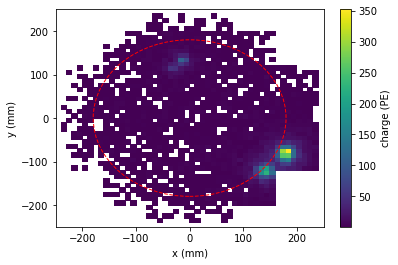

In [275]:
fig, ax = plt.subplots()
weights = myhf.get_weights(selectedSiPM[0], True)

plt.hist2d(selectedSiPM[0], selectedSiPM[1], weights = selectedSiPM[2], bins=(50, 50), range=((-250, 250), (-250, 250)), cmap='viridis', cmin=0.001)
circle1 = plt.Circle((0, 0), 180, edgecolor = 'red', fill = False ,linestyle = '--')
ax.add_artist(circle1)
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
#plt.title('charge (PE)')

plt.colorbar(label='charge (PE)')

In [ ]:
neutron_interactions = mother_particles.final_proc
plt.hist(neutron_interactions, alpha=0.6, color='r')
plt.xticks(rotation=45)

plt.show()

In [263]:
mother_particles

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
317,108004,1,neutron,1,0,0.0,315.149994,275.100006,0.0,-139.766266,...,0.0,-0.969312,0.0,-0.0,-0.0,-0.0,0.0005,691.612976,none,nCapture


In [264]:
daughter_particles

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
318,108004,4,Xe132,0,1,-139.766266,34.491505,157.027435,113102.007812,-139.767319,...,-5.677614,1.490238,-4.267533,-0.0,0.0,-0.0,0.000214,0.001353,nCapture,Scintillation
319,108004,3,gamma,0,1,-139.766266,34.491505,157.027435,113102.007812,176.704926,...,4.294756,-1.439865,0.562261,0.0,-0.0,0.0,4.564458,336.344940,nCapture,conv
432,108004,2,gamma,0,1,-139.766266,34.491505,157.027435,113102.007812,45.874607,...,1.422735,-0.034884,3.706392,-0.0,0.0,0.0,3.970230,669.258057,nCapture,phot


In [267]:
hits = pd.read_hdf(file, 'MC/hits')
evt_hits = hits[hits.event_id == eventID]

xt = evt_hits.x
yt = evt_hits.y
zt = evt_hits.z
et = evt_hits.energy*1000

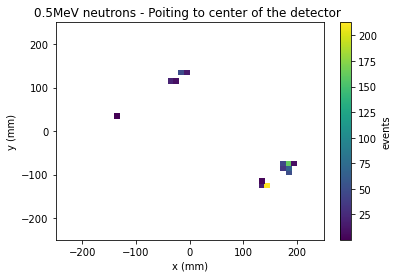

In [268]:
plt.hist2d(xt, yt, weights = et, bins=(50, 50), range=((-250, 250), (-250, 250)), cmap='viridis', cmin=0.001)
#range=((-50, 50), (-50, 50)),
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('0.5MeV neutrons - Poiting to center of the detector ')
#plt.xlim((0.0,1.5))
plt.colorbar(label='energy (keV)')

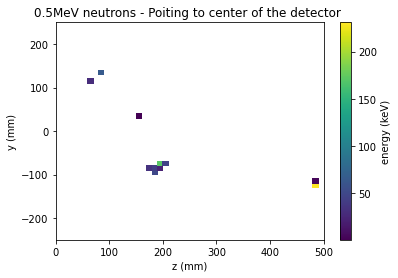

In [283]:
plt.hist2d(zt, yt, weights = et, bins=(50, 50), range=((0, 500), (-250, 250)), cmap='viridis', cmin=0.001)
#range=((-50, 50), (-50, 50)),
plt.xlabel('z (mm)')
plt.ylabel('y (mm)')
plt.title('0.5MeV neutrons - Poiting to center of the detector ')
#plt.xlim((0.0,1.5))
plt.colorbar(label='energy (keV)')

In [277]:
evt_hits

,event_id,x,y,z,time,energy,label,particle_id,hit_id
267,108004,-139.767319,34.491779,157.026642,113102.085938,0.000214,ACTIVE,4,0
268,108004,177.573044,-72.071983,198.637848,113103.132812,0.008452,ACTIVE,10639,0
269,108004,178.430344,-72.562820,198.790787,113103.132812,0.005857,ACTIVE,10639,1
270,108004,179.303879,-73.023018,198.947357,113103.140625,0.005464,ACTIVE,10639,2
271,108004,180.158844,-73.485405,199.164825,113103.140625,0.005209,ACTIVE,10639,3
...,...,...,...,...,...,...,...,...,...
601,108004,182.522079,-99.404816,187.965042,113103.257812,0.002188,ACTIVE,10638,37
602,108004,182.560471,-99.542938,188.045532,113103.257812,0.000104,ACTIVE,10638,38
603,108004,182.575668,-99.596939,188.077606,113103.257812,0.000296,ACTIVE,10638,39
604,108004,182.581009,-99.615936,188.088898,113103.257812,0.000013,ACTIVE,10638,40


In [255]:
selectedSiPM, selectedSiPM_x, selectedSiPM_y, selectedSiPM_q = [],[],[],[]
total = len(sns_response_evt.event_id)-1
for entry in range(0,total):
    sns = sns_response_evt.sensor_id.values[entry]
    q = sns_response_evt.charge.values[entry]
    #note! SiPM have a sns number >100, while PMTs are defined below 100 
    if((sns > 1000) & (q>3)):
        x_pos = sipm_map[sipm_map.sensor_id == sns].x.values[0]
        y_pos = sipm_map[sipm_map.sensor_id == sns].y.values[0]
        q = sns_response_evt.charge.values[entry]
        selectedSiPM_x.append(x_pos)
        selectedSiPM_y.append(y_pos)
        selectedSiPM_q.append(q)
    else:
        continue
    
selectedSiPM.append(selectedSiPM_x)
selectedSiPM.append(selectedSiPM_y)
selectedSiPM.append(selectedSiPM_q)

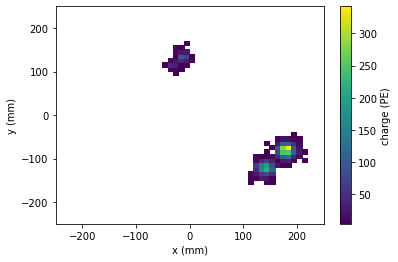

In [256]:
weights = myhf.get_weights(selectedSiPM[0], True)

plt.hist2d(selectedSiPM[0], selectedSiPM[1], weights = selectedSiPM[2], bins=(50, 50), range=((-250, 250), (-250, 250)), cmap='viridis', cmin=0.001)
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
#plt.title('charge (PE)')

plt.colorbar(label='charge (PE)')

In [288]:
selectedSiPM, selectedSiPM_x, selectedSiPM_y, selectedSiPM_q = [],[],[],[]
total = len(sns_response_evt.event_id)-1
for entry in range(0,total):
    sns = sns_response_evt.sensor_id.values[entry]
    q = sns_response_evt.charge.values[entry]
    #note! SiPM have a sns number >100, while PMTs are defined below 100 
    if((sns > 1000) & (q>3)):
        x_pos = sipm_map[sipm_map.sensor_id == sns].x.values[0]
        y_pos = sipm_map[sipm_map.sensor_id == sns].y.values[0]
        r_pos = math.sqrt(x_pos**2 + y_pos**2)
        if(r_pos<150):
            q = sns_response_evt.charge.values[entry]
            selectedSiPM_x.append(x_pos)
            selectedSiPM_y.append(y_pos)
            selectedSiPM_q.append(q)
        else:
            continue
    else:
        continue
    
selectedSiPM.append(selectedSiPM_x)
selectedSiPM.append(selectedSiPM_y)
selectedSiPM.append(selectedSiPM_q)

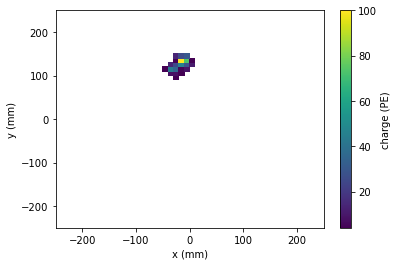

In [289]:
weights = myhf.get_weights(selectedSiPM[0], True)

plt.hist2d(selectedSiPM[0], selectedSiPM[1], weights = selectedSiPM[2], bins=(50, 50), range=((-250, 250), (-250, 250)), cmap='viridis', cmin=0.001)
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
#plt.title('charge (PE)')

plt.colorbar(label='charge (PE)')